## Projekat iz Neuralnih mreža 
Maša Tiosavljević 2023/3004

In [17]:
import random
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
from pyexpat import features
from sklearn.model_selection import train_test_split, StratifiedKFold
import model_eeg_to_visual
import eeg_lstm_model
import visual_resnet
import gem_cim_model
import lem_cim_model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from model_eeg_to_visual import EEGEfficientNetModel
from collections import defaultdict

## Učitavanje EEG signala i vizuelnih stimulusa

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)
#print(torch.__version__)

data = torch.load(r"C:\Users\masat\Downloads\eeg_14_70_std.pth")
dataset = data['dataset']
labels = data["labels"]
images = data["images"]

C:\Users\masat\AppData\Local\Temp\ipykernel_40752\3680489163.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(r"C:\Users\masat\Downloads\eeg_14_70_std.p

In [4]:
dataset_eeg = [d for d in dataset if d['label'] != 33]
true_labels = []
true_images = []

dataset_eeg = sorted(dataset_eeg, key=lambda d: d['label']) # ovim smo sortirali sve raspoložive podatke po labelama

In [5]:
for d in dataset_eeg:
    if d['label'] == 39:
        d['label'] = 33
    d['eeg'] = d['eeg'][:,20:460]
    true_labels.append(d['label'])
    true_images.append(d['image'])

all_eeg = np.concatenate([sample['eeg'][np.newaxis, ...] for sample in dataset_eeg], axis=0)  
channel_means = all_eeg.mean(axis=(0, 2), keepdims=True)  
channel_stds = all_eeg.std(axis=(0, 2), keepdims=True)
for sample in dataset_eeg:
    sample['eeg'] = (sample['eeg'] - channel_means[0]) / channel_stds[0]

unique_pairs = list(set(zip(true_images, true_labels)))
unique_pairs_sorted = sorted(unique_pairs, key=lambda x: (x[1], x[0]))
true_images = [pair[0] for pair in unique_pairs]
true_labels = [pair[1] for pair in unique_pairs]

true_images_sorted = [pair[0] for pair in unique_pairs_sorted]
true_labels_sorted = [pair[1] for pair in unique_pairs_sorted]

C:\Users\masat\AppData\Local\Temp\ipykernel_40752\4195043818.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sample['eeg'] = (sample['eeg'] - channel_means[0]) / channel_stds[0]


In [6]:
#### Učitavanje odgovarajućih vizuelnih stimulusa za svakog ispitanika ####

visual_stimuli = []
images_root = "C:/Users/masat/Desktop/ImageNetSubset"
labels_exceptions = [18, 25, 26]

transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 255] -> [0, 1] [C, H, W]
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

counter = 0
subfolders = sorted(os.listdir(images_root), key=int)[:-1]
for subfolder in subfolders:
    subfolder_path = os.path.join(images_root, subfolder)
    if os.path.isdir(subfolder_path): 
        for filename in os.listdir(subfolder_path):
            if filename.lower().endswith((".jpg", ".png", ".jpeg")):
                img_path = os.path.join(subfolder_path, filename)
                image = Image.open(img_path).convert("RGB")
                tensor_image = transform(image)
                counter = counter + 1
                if(counter not in [949, 1298, 1347]):
                    visual_stimuli.append(tensor_image)



visual_stimuli = torch.stack(visual_stimuli, dim=0)
true_images_sorted = torch.tensor(true_images_sorted)
true_labels_sorted = torch.tensor(true_labels_sorted)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8250805..2.595253].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0180554..2.2448456].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9567133..2.4026227].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0655904..1.7749386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.113201..2.6400006].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8737128..2.4887471].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8862804.

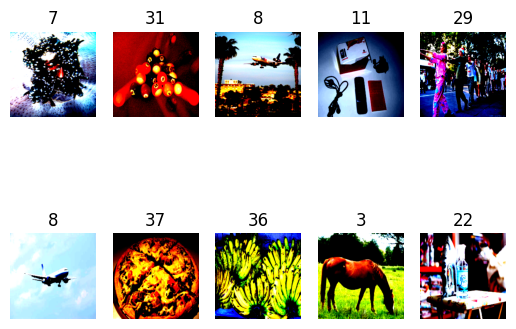

In [7]:
indices = np.random.randint(0,11000, size=10)

plt.figure()
for i in range(0,10):   
    plt.subplot(2,5,i+1)
    ind = torch.where(true_images_sorted==dataset_eeg[indices[i]]['image'])[0].item()
    img = visual_stimuli[ind].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(str(dataset_eeg[indices[i]]['label']))
    #plt.title(true_labels_sorted[ind])
    plt.axis("off")


## Vizuelni stimulusi - Klasifikacija pomoću ResNet50 (CIM)

In [8]:
visual_train, visual_test, y_train, y_test = train_test_split(visual_stimuli, true_labels_sorted, test_size=0.15, random_state=42, stratify=true_labels_sorted)
visual_train, visual_val, y_train, y_val = train_test_split(visual_train, y_train, test_size=0.214285714, random_state=42, stratify=y_train)

#skf = StratifiedKFold(n_splits=10)
#learning_rates = [0.1]

#average_train = []
#average_val = []

#for lr in learning_rates: 

#    train_acc = []
#    val_acc = []
#    print(f"Learning rate {lr}")

#    for i, (train_index, test_index) in enumerate(skf.split(visual_train, y_train)):
        
#        model, criterion, optimizer, scheduler = visual_resnet.build_model(lr=lr)
#        model, ta, va = visual_resnet.train_model(model, criterion, optimizer, scheduler, visual_train[train_index], y_train[train_index], visual_train[test_index], y_train[test_index], 128,100)
#        train_acc.append(ta)
#        val_acc.append(va)
#        print(f"Fold {i} done")

#    average_train.append(np.mean(train_acc))
#    average_val.append(np.mean(val_acc))

In [8]:
#model, criterion, optimizer, scheduler = visual_resnet.build_model(lr=0.1)
#model, ta, va = visual_resnet.train_model(model, criterion, optimizer, scheduler, visual_train, y_train, visual_val, y_val, 64, 200)

In [9]:
#torch.save(model, 'C:/users/masat/Desktop/Projekat iz Neuralnih/resnet50_finetuned.pth')
model = torch.load('C:/users/masat/Desktop/Projekat iz Neuralnih/resnet50_finetuned.pth', weights_only=False)
model.eval()
criterion = nn.CrossEntropyLoss()
outputs = model(visual_test.to(device))
loss = criterion(outputs, y_test.to(device))
_, predicted = outputs.max(1)
print(f"Accuracy on test set is {accuracy_score(y_test, predicted.cpu().numpy())}")

Accuracy on test set is 0.8532423208191127


<Figure size 3000x3000 with 0 Axes>

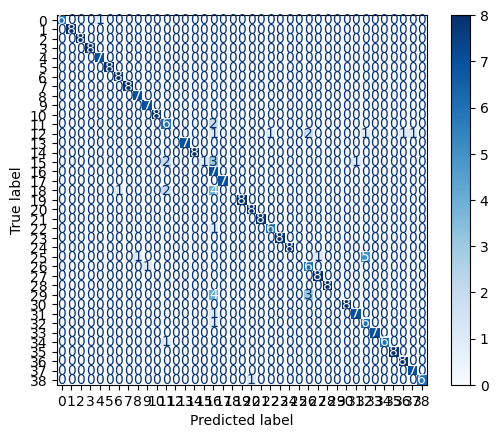

In [10]:
cm = confusion_matrix(y_test, predicted.cpu().numpy())
plt.figure(figsize=(30,30))
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)

## Sirovi EEG signali - Klasifikacija pomoću EEG-LSTM mreže (LEM)

In [9]:
eeg_train = []
y_train_eeg  = []
eeg_test = []
y_test_eeg = []
eeg_val = []
y_val_eeg = []

for d in dataset_eeg:
    ind = torch.where(true_images_sorted==d['image'])[0].item()
    if any(torch.equal(visual_stimuli[ind], t) for t in visual_train):
        eeg_train.append(d['eeg'])
        y_train_eeg.append(d['label'])
    elif any(torch.equal(visual_stimuli[ind], t) for t in visual_val):
        eeg_val.append(d['eeg'])
        y_val_eeg.append(d['label'])
    else:
        eeg_test.append(d['eeg'])
        y_test_eeg.append(d['label'])

eeg_train = torch.stack(eeg_train, dim=0).to(device)
y_train_eeg = torch.tensor(y_train_eeg).to(device)

eeg_val = torch.stack(eeg_val, dim=0).to(device)
y_val_eeg = torch.tensor(y_val_eeg).to(device)

eeg_test = torch.stack(eeg_test, dim=0).to(device)
y_test_eeg = torch.tensor(y_test_eeg).to(device)

print(visual_train.size())
print(visual_test.size())
print(visual_val.size())

print(eeg_train.size())
print(eeg_test.size())
print(eeg_val.size())

torch.Size([1299, 3, 224, 224])
torch.Size([293, 3, 224, 224])
torch.Size([355, 3, 224, 224])
torch.Size([7794, 128, 440])
torch.Size([1758, 128, 440])
torch.Size([2130, 128, 440])


In [10]:
eeg_train = eeg_train.permute(0, 2, 1)  # Convert from (batch_size, 128, 440) to (batch_size, 440, 128)
eeg_val = eeg_val.permute(0, 2, 1)
eeg_test = eeg_test.permute(0, 2, 1)
print(eeg_train.size())
print(eeg_test.size())
print(eeg_val.size())

torch.Size([7794, 440, 128])
torch.Size([1758, 440, 128])
torch.Size([2130, 440, 128])


In [13]:
#import importlib
#importlib.reload(eeg_lstm_model)

In [14]:
model, criterion, optimizer, scheduler = eeg_lstm_model.build_model(n_timesteps=440, n_features=128, n_classes=39, lr=0.001)
model = eeg_lstm_model.train_model(model, criterion, optimizer, scheduler, eeg_train, y_train_eeg, eeg_val, y_val_eeg, batch_size=256, epochs=100)

Epoch 1: Train Loss=3.6780, Train Acc=0.0264, Val Loss=3.6641, Val Acc=0.0282
Epoch 2: Train Loss=3.6576, Train Acc=0.0317, Val Loss=3.6159, Val Acc=0.0404
Epoch 3: Train Loss=3.4880, Train Acc=0.0526, Val Loss=3.2114, Val Acc=0.0714
Epoch 4: Train Loss=3.0899, Train Acc=0.0907, Val Loss=2.7810, Val Acc=0.1385
Epoch 5: Train Loss=2.7277, Train Acc=0.1451, Val Loss=2.5278, Val Acc=0.1765
Epoch 6: Train Loss=2.5086, Train Acc=0.1859, Val Loss=2.3609, Val Acc=0.1958
Epoch 7: Train Loss=2.2603, Train Acc=0.2452, Val Loss=2.2833, Val Acc=0.2150
Epoch 8: Train Loss=2.0388, Train Acc=0.3054, Val Loss=2.2267, Val Acc=0.2056
Epoch 9: Train Loss=1.8896, Train Acc=0.3442, Val Loss=2.1755, Val Acc=0.2338
Epoch 10: Train Loss=1.7455, Train Acc=0.3913, Val Loss=2.0347, Val Acc=0.2624
Epoch 11: Train Loss=1.5804, Train Acc=0.4430, Val Loss=2.1008, Val Acc=0.2601
Epoch 12: Train Loss=1.4989, Train Acc=0.4796, Val Loss=2.1938, Val Acc=0.2329
Epoch 13: Train Loss=1.3651, Train Acc=0.5185, Val Loss=2.173

tensor([ 0, 21,  8,  ..., 33, 12, 33], device='cuda:0')
tensor([ 0,  0,  0,  ..., 33, 33, 33], device='cuda:0')
0.29408418657565416


<Figure size 6000x6000 with 0 Axes>

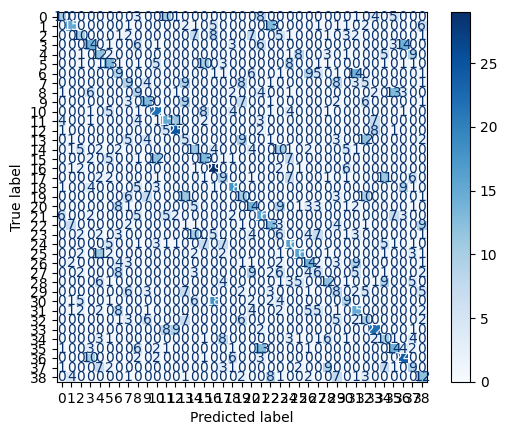

In [15]:
y_pred = eeg_lstm_model.predict(model, criterion, optimizer, scheduler, eeg_test, y_test_eeg)
print(y_pred)
print(y_test_eeg)
print(accuracy_score(y_test_eeg.cpu().numpy(), y_pred.cpu().numpy()))

cm = confusion_matrix(y_test_eeg.cpu().numpy(), y_pred.cpu().numpy())
plt.figure(figsize=(60,60))
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)

## LEM + CIM konkatenacija

In [11]:
# Ovde treba da transformišem signale u onu formu po subjektu!!!!!!!! i kada ih tako transformišem, to će mi biti ulaz u neuralnu mrežu

stimulus_dict = defaultdict(list)

for d in dataset_eeg:
    stimulus_dict[d['image']].append(d['eeg'])

mean_by_stimulus = {}

for stim, eeg_list in stimulus_dict.items():
    stacked = torch.stack(eeg_list)  
    mean_by_stimulus[stim] = stacked.mean(dim=0)

# Sada ćemo da grupišemo odgovarajuće vizuelne stimuluse sa slikama - to će biti naš skup podataka za LEM + CIM model

In [12]:
eeg_train = []
y_train_eeg  = []
eeg_test = []
y_test_eeg = []
eeg_val = []
y_val_eeg = []

for stim_id, eeg_tensor in mean_by_stimulus.items():
    ind = torch.where(true_images_sorted==stim_id)[0].item() # našla sam poziciju slike s tim ID-em

    if any(torch.equal(visual_stimuli[ind], t) for t in visual_train):
        eeg_train.append(eeg_tensor)
        y_train_eeg.append(true_labels_sorted[ind])
    elif any(torch.equal(visual_stimuli[ind], t) for t in visual_val):
        eeg_val.append(eeg_tensor)
        y_val_eeg.append(true_labels_sorted[ind])
    else:
        eeg_test.append(eeg_tensor)
        y_test_eeg.append(true_labels_sorted[ind])

eeg_train = torch.stack(eeg_train, dim=0).permute(0, 2, 1)
y_train_eeg = torch.tensor(y_train_eeg)

eeg_val = torch.stack(eeg_val, dim=0).permute(0, 2, 1)
y_val_eeg = torch.tensor(y_val_eeg)

eeg_test = torch.stack(eeg_test, dim=0).permute(0, 2, 1)
y_test_eeg = torch.tensor(y_test_eeg)

print(visual_train.size())
print(visual_test.size())
print(visual_val.size())

print(eeg_train.size())
print(eeg_test.size())
print(eeg_val.size())

torch.Size([1299, 3, 224, 224])
torch.Size([293, 3, 224, 224])
torch.Size([355, 3, 224, 224])
torch.Size([1299, 440, 128])
torch.Size([293, 440, 128])
torch.Size([355, 440, 128])


In [ ]:
import importlib
importlib.reload(lem_cim_model)

model = lem_cim_model.LEMCIMModel((440,128), (3,224,224)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, min_lr=1e-5)

model = lem_cim_model.train_model(model, criterion, optimizer, scheduler, eeg_train, visual_train, y_train, eeg_val, visual_val, y_val, 16, 200)

Epoch 1: Train Loss=2.1834, Train Acc=0.4981, Val Loss=1.8757, Val Acc=0.6169
Epoch 2: Train Loss=1.0663, Train Acc=0.7175, Val Loss=4.4627, Val Acc=0.3155
Epoch 3: Train Loss=1.1995, Train Acc=0.6882, Val Loss=2.4589, Val Acc=0.4704
Epoch 4: Train Loss=0.9109, Train Acc=0.7506, Val Loss=2.1135, Val Acc=0.5662
Epoch 5: Train Loss=0.9620, Train Acc=0.7275, Val Loss=2.2874, Val Acc=0.5127
Epoch 6: Train Loss=0.8442, Train Acc=0.7644, Val Loss=2.7968, Val Acc=0.4873
Epoch 7: Train Loss=0.3775, Train Acc=0.9007, Val Loss=0.9527, Val Acc=0.7577
Epoch 8: Train Loss=0.1194, Train Acc=0.9677, Val Loss=0.8700, Val Acc=0.7577
Epoch 9: Train Loss=0.0799, Train Acc=0.9808, Val Loss=0.8322, Val Acc=0.7831
Epoch 10: Train Loss=0.0549, Train Acc=0.9869, Val Loss=0.8282, Val Acc=0.7831
Epoch 11: Train Loss=0.0504, Train Acc=0.9854, Val Loss=0.8641, Val Acc=0.7690
Epoch 12: Train Loss=0.0407, Train Acc=0.9915, Val Loss=0.8476, Val Acc=0.7718
Epoch 13: Train Loss=0.0538, Train Acc=0.9885, Val Loss=0.846

In [15]:
print(lem_cim_model.model_outputs(model, criterion, optimizer, eeg_test, visual_test, y_test, 32))

0.7815699658703071


## GEM + CIM konkatenacija

In [19]:
eeg_train = eeg_train.permute(0, 2, 1)
eeg_val = eeg_val.permute(0, 2, 1)
eeg_test = eeg_test.permute(0, 2, 1)
print(eeg_train.size())
print(eeg_test.size())
print(eeg_val.size())

torch.Size([1299, 128, 440])
torch.Size([293, 128, 440])
torch.Size([355, 128, 440])


In [29]:
import importlib
importlib.reload(gem_cim_model)

model = gem_cim_model.GEMCIMModel((128, 440), (3,224,224)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, min_lr=1e-5)

model = lem_cim_model.train_model(model, criterion, optimizer, scheduler, eeg_train, visual_train, y_train, eeg_val, visual_val, y_val, 16, 200)

Epoch 1: Train Loss=3.5797, Train Acc=0.1078, Val Loss=3.3621, Val Acc=0.4507
Epoch 2: Train Loss=3.1657, Train Acc=0.5558, Val Loss=2.6157, Val Acc=0.8563
Epoch 3: Train Loss=2.3588, Train Acc=0.7875, Val Loss=1.4795, Val Acc=0.9099
Epoch 4: Train Loss=1.3938, Train Acc=0.8984, Val Loss=0.6993, Val Acc=0.9408
Epoch 5: Train Loss=0.7632, Train Acc=0.9323, Val Loss=0.3621, Val Acc=0.9634
Epoch 6: Train Loss=0.4832, Train Acc=0.9615, Val Loss=0.3508, Val Acc=0.9606
Epoch 7: Train Loss=0.4533, Train Acc=0.9738, Val Loss=0.3370, Val Acc=0.9634
Epoch 8: Train Loss=0.4346, Train Acc=0.9677, Val Loss=0.3330, Val Acc=0.9634
Epoch 9: Train Loss=0.4109, Train Acc=0.9777, Val Loss=0.3212, Val Acc=0.9577
Epoch 10: Train Loss=0.4046, Train Acc=0.9692, Val Loss=0.3069, Val Acc=0.9690
Epoch 11: Train Loss=0.3919, Train Acc=0.9723, Val Loss=0.2986, Val Acc=0.9690
Epoch 12: Train Loss=0.3903, Train Acc=0.9738, Val Loss=0.2954, Val Acc=0.9662
Epoch 13: Train Loss=0.3997, Train Acc=0.9692, Val Loss=0.283

In [30]:
print(gem_cim_model.model_outputs(model, criterion, optimizer, eeg_test, visual_test, y_test, 32))

0.9522184300341296
